In [1]:
!pip install pandas
!pip install threadpoolctl==3.1.0
!pip install user_agents
# pip install retentioneering
!pip install geoip2
# !pip install tensorflow


In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import time
from user_agents import parse
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# получаем данные из БД, и в переменную df отбираем только те, где user_agent и request_path != None

data = pd.read_csv("database.csv", delimiter=';', on_bad_lines='skip')
df = data[~data[['http_user_agent','request_path']].isna().any(axis=1)].reset_index(drop=True)
df_main = df

<ipython-input-3-9f254c559287>:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("database.csv", delimiter=';', on_bad_lines='skip')


In [4]:
# с помощью библиотеки user_agents из user_agent вытаскиваем ОС, браузер и устройство пользователя и добавляем в df

stack_device = []
stack_os = []
stack_browser = []
is_mozilla = []


unique_data_ua = df['http_user_agent'].tolist()
for ua_string in unique_data_ua:
    ua = parse(ua_string)
    stack_device.append(ua.device.family)
    stack_os.append(ua.os.family)
    stack_browser.append(ua.browser.family)

    if 'Mozilla' in ua_string:
        is_mozilla.append(1)
        continue
    else:
        is_mozilla.append(0)

df['device'] = stack_device
df['os'] = stack_os
df['browser']= stack_browser
df['is_mozilla'] = is_mozilla

In [5]:
# с помощью бесплатной БД GeoIP вычисляем по ip страну и континент, откуда заходил пользователь

import geoip2.database

stack_country = []
stack_continent = []

reader = geoip2.database.Reader('GeoLite2-Country.mmdb')
unique_ip = df['remote_addr'].tolist()

for i in unique_ip:
    response = reader.country(i)
    stack_country.append(response.country.name)
    stack_continent.append(response.continent.name)

reader.close()

df['country'] = stack_country
df['continent'] = stack_continent
df = df.drop('remote_addr', axis=1)
df = df.drop('http_user_agent', axis=1)

In [6]:
# Подготовка данных (http_referer и request_path) к кластеризации 

df['http_referer'] = df['http_referer'].fillna('http://nan')
# пссмотреть в pd
# Нахождение самых популярных слов для request_path и http_referer
import re
from collections import Counter

def most_pop_words(naming, n):
    urls = df[naming].tolist()


    stack_u = []
    pattern = r'(?<=\/)[^\/]+'
    for i in range(df.shape[0]):
        words = re.findall(pattern, urls[i])
        stack_u += words

    counter = Counter(stack_u)
    most_pop_words = [key for key, value in counter.items() if value > n]
    
    return most_pop_words
    
most_pop_words_request_path = most_pop_words('request_path', 30)
most_pop_words_http_referer = most_pop_words('http_referer', 10)


In [7]:
# преобразование категориальных данных в числовые с помощью "мешка слов" для http_referer и request_path
dict_of_df = {}

vectorizer = CountVectorizer(token_pattern=r'(?<=\/)[^\/]+', vocabulary= most_pop_words_request_path)
transformed_data = vectorizer.fit_transform(df['request_path'])
transformed_df1 = pd.DataFrame(transformed_data.toarray(), columns=vectorizer.get_feature_names_out())
dict_of_df['request_path'] = transformed_df1

# преобразование в вектор для http_referer
vectorizer = CountVectorizer(token_pattern=r'(?<=\/)[^\/]+', vocabulary= most_pop_words_http_referer)
transformed_data = vectorizer.fit_transform(df['http_referer'])
transformed_df2 = pd.DataFrame(transformed_data.toarray(), columns=vectorizer.get_feature_names_out())
dict_of_df['http_referer'] = transformed_df2

df = pd.concat([df,transformed_df1, transformed_df2], axis=1)

C:\Users\Egor\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\Egor\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [8]:
# преобразование категориальных данных в числовые с помощью "One-Hot-Encoder" для других кат. данных

from sklearn.preprocessing import OneHotEncoder

strs = ['country', 'continent','device', 'os', 'browser','request_method', 'request_proto']
encoder = OneHotEncoder(handle_unknown='ignore',drop='first')

for i in strs:
    data_to_encode = df[[i]]
    encoder.fit(data_to_encode)
    encoded_column_names = list(encoder.get_feature_names_out(data_to_encode.columns))
    encoded_data = encoder.transform(data_to_encode)
    encoder_df = pd.DataFrame(encoded_data.toarray(), columns=encoded_column_names)
    df = pd.concat([df,encoder_df], axis=1)
    dict_of_df[i] = encoder_df 

In [9]:
# выделяем только время в time_local и пересчитываем на секунды
df['time_local'] = pd.to_datetime(df['time_local'])
def time_to_seconds(time):
    return time.hour * 3600 + time.minute * 60 + time.second

df['time_local'] = pd.to_datetime(df['time_local'], format='%H:%M:%S').dt.time
df['time_local'] = df['time_local'].apply(lambda x: time_to_seconds(x))

In [10]:
# удаление след. слобцов

df = df.drop(['http_referer',
              'request_method',
              'request_path',
              'request_proto',
              'device',
              'os',
              'browser',
             'country',
             'continent'], axis =1)


In [11]:
# Стандартизация данных

from sklearn.preprocessing import StandardScaler

# X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)

# numeric = ['body_bytes_sent', 'time_local','request_time', 'status']
# scaler = StandardScaler()

# scaler.fit(X_train[numeric])
# X_train[numeric] = scaler.transform(X_train[numeric])
# X_test[numeric] = scaler.transform(X_test[numeric])

In [12]:
# метод локтя

# wcss = []

# for i in range(1, 15):
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, random_state = 42)
#     kmeans.fit(X_train)
#     wcss.append(kmeans.inertia_)

# plt.figure(figsize = (10,6))

# plt.plot(range(1,15), wcss, marker='o', linestyle='--')
# plt.title('Выбор количества кластеров методом локтя')
# plt.xlabel('Количество кластеров')
# plt.ylabel('WCSS')
# plt.show()

In [13]:
# Кластеризация данных с помощью метода k-means

from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(X_train)

# # Кластеризация данных с помощью KMeans после уменьшения размерности
# kmeans = KMeans(n_clusters=5, max_iter=300, random_state=42)
# kmeans.fit(X_tsne)

# # Получение меток кластеров для каждой точки данных
# labels = kmeans.labels_

# # Визуализация кластеров с использованием t-SNE
# plt.figure(figsize=(8, 6))
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='*', label='Centroids')
# plt.title('Кластеризация с помощью KMeans после t-SNE')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.legend()
# plt.show()

In [14]:
dict_of_df['is_mozilla'] = df['is_mozilla']

In [15]:
# кластеризация по user_agent

train_test_df = pd.concat([dict_of_df['os'],
                   dict_of_df['browser'],
                   dict_of_df['is_mozilla'],
                   dict_of_df['device'],
                   df['time_local'],
                   dict_of_df['request_path'], 
                   df['body_bytes_sent'], 
                   df['request_time'],
                   df_main['remote_addr'],
                   df_main['http_user_agent']], 
                   axis=1)

X_train, X_test = train_test_split(train_test_df.drop(['remote_addr', 'http_user_agent'], axis=1), test_size=0.3, random_state=42)

# numeric = ['body_bytes_sent', 'time_local','request_time', 'status']
numeric = ['body_bytes_sent', 'time_local', 'request_time']
scaler = StandardScaler()

scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])



C:\Users\Egor\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Egor\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Egor\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Egor\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

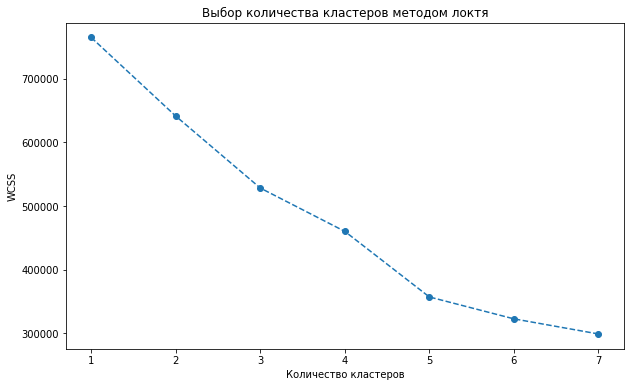

In [16]:
# Метод локтя для отбора количества кластеров

wcss = [] # сумма квадратов расстояния между каждой точкой и центроидом кластера

for i in range(1, 8):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, random_state = 42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (10,6))

plt.plot(range(1,8), wcss, marker='o', linestyle='--')
plt.title('Выбор количества кластеров методом локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

C:\Users\Egor\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


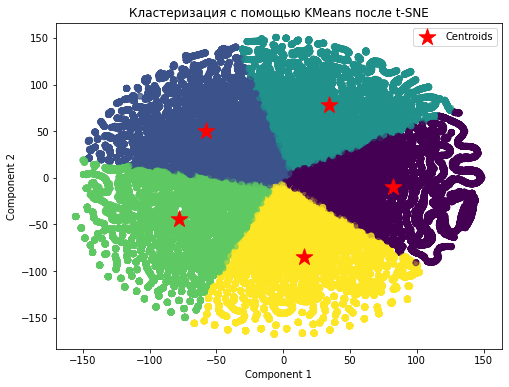

In [17]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train)

# Кластеризация данных с помощью KMeans после уменьшения размерности
kmeans = KMeans(n_clusters=5, max_iter=300, random_state=42)
kmeans.fit(X_tsne)

# Получение меток кластеров для каждой точки данных
labels = kmeans.labels_

# Визуализация кластеров с использованием t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='*', label='Centroids')
plt.title('Кластеризация с помощью KMeans после t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [18]:
# проверка качества кластеризации по признаку user_agent

from sklearn.metrics import silhouette_score

predicted_labels = kmeans.labels_

# Оценка качества кластеризации с помощью Silhouette Score
silhouette_avg = silhouette_score(X_train, predicted_labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.04048387786340303


In [19]:
# присваивание меток кластера 

# train_test_df['class'] = kmeans.labels_

ValueError: Length of values (140534) does not match length of index (200764)

In [ ]:
# выделение каждого кластера из общего датасета 

# df_0 = train_test_df[train_test_df['class'] = 0]
# df_1 = train_test_df[train_test_df['class'] = 1]
# df_2 = train_test_df[train_test_df['class'] = 2]
# df_3 = train_test_df[train_test_df['class'] = 3]
# df_4 = train_test_df[train_test_df['class'] = 4]


# stack_cluster=[df_0, df_1, df_2, df_3, df_4]

In [ ]:
# разделение данных на сессии 

#Сессии пользователей (remote_addr)
# finally_stack_cluster = []

# for cluster_data in stack_cluster:
#     event_df = cluster_data
#     event_df.sort_values(by=['remote_addr','http_user_agent', 'time_local'], inplace=True)
#     event_df['time_diff'] = event_df.groupby(['remote_addr','http_user_agent'])['time_local'].diff(1)
#     max_session_gap = pd.Timedelta(seconds=30)
#     session_mask = (event_df['time_diff'].isnull()) | (event_df['time_diff'].fillna(pd.Timedelta(seconds=0)) > max_session_gap)
#     event_df['session_id'] = (session_mask).cumsum()
#     #Время, проведенное на странице
#     event_df.sort_values(by=['remote_addr', 'time_local', 'session_id'], inplace=True)
#     event_df['time_on_page'] = event_df.groupby(['remote_addr','session_id'])['time_local'].diff(1)

#     #Перевод времени, проведенное на странице в секунды
#     event_df['time_on_page'] = event_df['time_on_page'].dt.total_seconds()


#     #События, которые были первыми в сессии
#     event_df['is_first_event_in_session'] = event_df.groupby('session_id').cumcount() == 0

#     event_df = event_df.sort_index()
#     finally_stack_cluster.append(event_df)

In [ ]:
# построение марковских цепей


